In [1]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import numpy as np
from sklearn.model_selection import train_test_split

import keras

from keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

2022-04-27 17:48:34.368490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 17:48:34.368546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Dataset

Read the test and training data into variables. Images are already processed here, i.e. correctly sized, converted to numpy arrays (..).

In [2]:
train_dir = './ds/train/'
test_dir = './ds/test/'

classes = [os.path.basename(x[0]) for x in os.walk(train_dir) if x[0]][1:]
num_classes = len(classes)
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [3]:
def load_data(path):
    data = []
    for c, category in enumerate(classes):
        images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path + category) for f in filenames]

        for img_path in images:
            img = image.load_img(img_path, target_size=(256, 256))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)

            data.append({'x' : np.array(x[0]), 'y' : c})

    return data


data_train_val = load_data(train_dir)
data_test = load_data(test_dir)

In [4]:
X_train_val, y_train_val = np.array([t["x"] for t in data_train_val]), [t["y"] for t in data_train_val]
X_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.2)

# Convert classes to one-hot vectors
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Train images:', len(y_train), y_train.shape)
print('Val images:', len(y_val), y_val.shape)
print('Test images:', len(y_test), y_test.shape)

Train images: 872 (872, 21)
Val images: 219 (219, 21)
Test images: 279 (279, 21)


## Data Enhancement

#### Balance classes

The imbalance in the training data is now reduced. Class weights are used to let the CNN pay special attention to classes that are underrepresented.

In [5]:
# Compute class weights to let the CNN pay attention to less frequent classes when fitting the model
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_integers),
                                     y=y_integers)
class_weights = dict(zip(np.unique(y_integers), class_weights))

#### Generate artificial images using shift, rotation, flip

Use an ImageDataGenerator to slightly change images in each epoch. Note that this is only done to training data, but not to validation data.

In [6]:
# Enrich train data set by rotation, flip, shift
gen_train = ImageDataGenerator(rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   data_format='channels_last',
                                   preprocessing_function=preprocess_input)

# No augmentation for test and validation sets
gen_val_test = ImageDataGenerator(data_format='channels_last',
                                  preprocessing_function=preprocess_input)

# Generate iterators for train/val/test sets
train_iter = gen_train.flow(X_train, y_train, batch_size=16, shuffle=True)
val_iter = gen_val_test.flow(X_val, y_val, batch_size=16, shuffle=True)
test_iter = gen_val_test.flow(X_test, y_test, batch_size=16, shuffle=True)


## Model Creation and Training

Create a CNN model using multiple convolutional layers. As opposed to constant a number of filters in each convolutional layer, this model increases number of filters in deeper layers as more complex features can be learned.

In [ ]:
def get_model():
    model = Sequential()
    print("Input dimensions:", X_train.shape[1:])

    model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # model.summary()

    return model


In [ ]:
baseline_model = get_model()

baseline_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Create checkpoints during training
filepath = './models/baseline_v2/baseline_v2_{epoch:02d}_{val_accuracy:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

callbacks_list = [checkpoint, lr]

# Train the model
history = baseline_model.fit(train_iter,
                    # batch_size=32,
                    epochs=75,
                    validation_data=val_iter,
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    workers=3)

#### Visualize training progress along epochs

Plot the (val_)accuracy and (val_)loss along epochs to identify over- and underfitting.

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label='validation')
ax.plot(history.history["loss"], label='train')
ax.legend(loc="upper right")
ax.set_title("Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label='validation')
ax2.plot(history.history["accuracy"], label='train')
ax2.legend(loc="lower right")
ax2.set_title("Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

## Evaluation

#### Analysis of model performance on test data

In [8]:
# NOTE: By default, the finished model is loaded from the repository in order to evaluate
# without compiling and fitting the model again. However, if you train again,
# uncomment the following line and comment the load_model() call below

# test_model = baseline_model
test_model = keras.models.load_model('./models/baseline_v2/baseline_v2_epochs=35_acc=47.h5')

y_pred = test_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

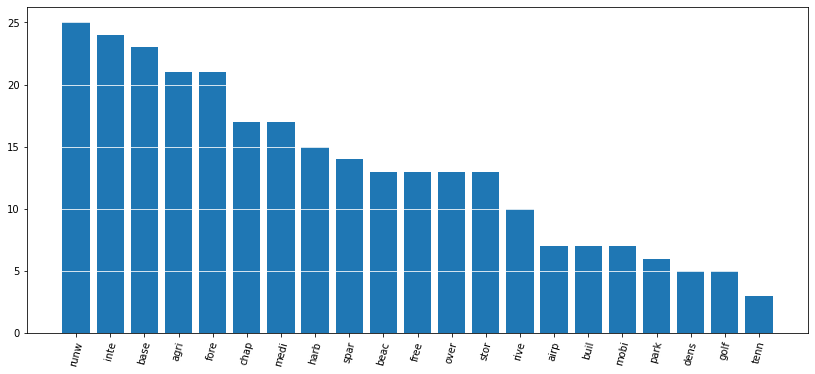

In [9]:
# Plot the distribution of predicted classes

unique, counts = np.unique(y_pred, return_counts=True)
ticks = np.arange(len(counts))
pred_dist = sorted(zip(classes, counts), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, [c[1] for c in pred_dist])
plt.xticks(ticks, [c[0][:4] for c in pred_dist], rotation=75)
plt.show()

Acc:  0.4731182795698925
Prec:  0.44915906180983317
Rec:  0.4731182795698925


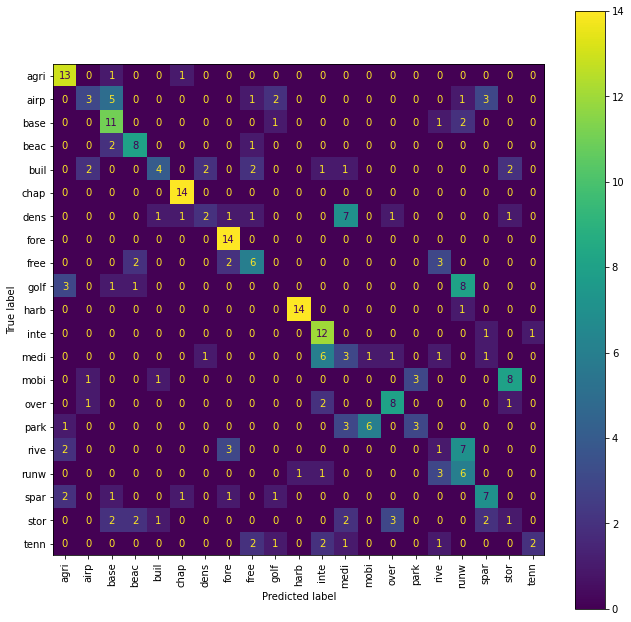

In [10]:
# Plot the confusion matrix and evaluate acc, prec and rec

cm = confusion_matrix(y_true, y_pred)
cm = np.round(cm, 2)

cmd = ConfusionMatrixDisplay(cm, display_labels=[c[:4] for c in classes])

fig, ax = plt.subplots(figsize=(11,11))
cmd.plot(ax=ax, xticks_rotation='vertical')

print('Acc: ', accuracy_score(y_true, y_pred))
print('Prec: ', precision_score(y_true, y_pred, average='weighted'))
print('Rec: ', recall_score(y_true, y_pred, average='weighted'))
# Acc:  0.4731182795698925
# Prec:  0.44915906180983317
# Rec:  0.4731182795698925